## Persistent

In [48]:
import sys
import time
import re
import random
import itertools
import pprint
import math
import psutil

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.patches as patches

from collections import defaultdict
from typing import Tuple, List, Set, Callable, NamedTuple, Union, Optional, Iterable, Dict
from multiprocessing import Pool

plt.rcParams['savefig.format'] = 'svg'
%config InlineBackend.figure_format = 'svg'
plt.rcParams['figure.figsize'] = (12, 12)


In [49]:
CPU_CORES = 16

In [50]:
class Point(NamedTuple):
    """An integer point in 2D space."""
    x: int
    y: int

In [51]:
class Line:
    """
    Represents a line defined by a rational slope and a point on the line.

    Attributes:
        slope (Union[QQ, str]): Rational slope of the line, or 'inf' for vertical lines.
        point (Point): An arbitrary point on the line.
        a (QQ): Coefficient of x in the standard form.
        b (QQ): Coefficient of y in the standard form.
        c (QQ): Constant term in the standard form.
        points (Set[Point]): Set of integer-coordinate points on the line within the grid.
    """

    def __init__(self, slope: Union[QQ, str], point: Point, grid_size: int = 100):
        """
        Initialize a line with a given slope and a point on the line.

        Args:
            slope (Union[QQ, str]): Rational slope of the line, or 'inf' for vertical lines.
            point (Point): A point on the line.
            grid_size (int): Maximum grid coordinate (inclusive).
        """
        self.slope = slope
        self.point = point

        x0, y0 = point.x, point.y
        if slope == 'inf':
            self.a = QQ(1)
            self.b = QQ(0)
            self.c = -QQ(x0)
            self.points = {Point(x0, y) for y in range(1, grid_size + 1) if 1 <= x0 <= grid_size}
        else:
            m = slope
            self.a = -m
            self.b = QQ(1)
            self.c = m * x0 - y0
            b = QQ(y0) - m * QQ(x0)
            self.points = {
                Point(x, int(y))
                for x in range(1, grid_size + 1)
                if (y := m * QQ(x) + b).denominator() == 1 and 1 <= int(y) <= grid_size
            }

    @classmethod
    def from_points(cls, p1: Point, p2: Point, grid_size: int) -> 'Line':
        dx = p2.x - p1.x
        dy = p2.y - p1.y
        if dx == 0:
            slope = 'inf'
        else:
            slope = QQ(dy) / QQ(dx)
        return cls(slope, p1, grid_size)

    @classmethod
    def from_point_slope_of_line(cls, p: Point, slope: Union[QQ, str], grid_size: int = 100) -> 'Line':
        return cls(slope, p, grid_size)

    @classmethod
    def from_standard_form(cls, a: QQ, b: QQ, c: QQ, grid_size: int = 100) -> 'Line':
        if b == 0:
            slope = 'inf'
            point = Point(-c / a, QQ(0))
        else:
            slope = -a / b
            point = Point(QQ(0), -c / b)
        return cls(slope, point, grid_size)


In [52]:
def are_collinear(p1: Point, p2: Point, p3: Point) -> bool:
    """
    Determine if three points are collinear.

    Args:
        p1 (Point): The first point as a named tuple with integer coordinates (x, y).
        p2 (Point): The second point as a named tuple with integer coordinates (x, y).
        p3 (Point): The third point as a named tuple with integer coordinates (x, y).

    Returns:
        bool: True if the three points are collinear, False otherwise.
    """
    x1, y1 = p1
    x2, y2 = p2
    x3, y3 = p3
    return (y1 - y2) * (x1 - x3) == (y1 - y3) * (x1 - x2)

In [53]:
def plot_points(points: Iterable[tuple], n: Optional[int] = None, title: str = "Points Plot", zero_index: bool = False):
    """
    Plot a set of points on an n x n grid.

    Args:
        points (Iterable[Tuple[int, int]]): Iterable of points to plot.
        n (Optional[int]): Grid size. If None, inferred from points.
        title (str): Title of the plot.
        zero_index (bool): If True, axes range from 0 to p-1. If False, from 1 to p.

    Returns:
        None
    """
    points = list(points)
    if not points:
        print("No points to plot.")
        return

    xs, ys = zip(*points)
    offset = 0 if zero_index else 1
    if n is None:
        n = max(max(xs), max(ys)) + 1

    fig, ax = plt.subplots(figsize=(6, 6))
    ax.scatter(xs, ys, s=100, c='blue', edgecolors='black')
    ax.set_xticks(range(offset, n + 1))
    ax.set_yticks(range(offset, n + 1))

    ax.grid(True, linestyle='--', alpha=0.5)
    ax.set_aspect('equal', adjustable='box')
    ax.set_title(title)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_xlim(offset - 1, n if zero_index else n + 1)
    ax.set_ylim(offset - 1, n if zero_index else n + 1)

    return fig, ax


In [54]:
def plot_lines(points: Iterable[Point], n: Optional[int] = None, title: str = "Lines Plot") -> None:
    """
    Plot a set of points and the lines connecting them on an n x n grid.

    Args:
        points (Iterable[Point]): Iterable of points to plot.
        n (Optional[int]): Grid size. If None, inferred from points.
        title (str): Title of the plot.

    Returns:
        None
    """
    xs, ys = zip(*[(pt.x, pt.y) for pt in points])
    plt.scatter(xs, ys, s = 30, color='black')

    remaining = {Point(x, y) for x in range(1, n + 1) for y in range(1, n + 1)}

    
    seen_lines = set()

    for p1, p2 in itertools.combinations(points, 2):
        line = Line.from_points(p1, p2, grid_size=n)
        key = (line.a, line.b, line.c)
        if key in seen_lines:
            continue
        seen_lines.add(key)

        lattice_pts = line.points

        for pt in lattice_pts:
            plt.scatter(pt.x, pt.y, color='red', s=10)
        remaining.difference_update(lattice_pts)

        
        pts = []
        a, b, c = line.a, line.b, line.c
        if b: pts += [(0, float(-c/b))] if 0 <= -c/b <= n+1 else []
        if b: pts += [(n+1, float((-a*(n+1)-c)/b))] if 0 <= (-a*(n+1)-c)/b <= n+1 else []
        if a: pts += [(float(-c/a), 0)] if 0 <= -c/a <= n+1 else []
        if a: pts += [(float((-b*(n+1)-c)/a), n+1)] if 0 <= (-b*(n+1)-c)/a <= n+1 else []
        x_vals, y_vals = zip(*pts)
        plt.plot(x_vals, y_vals, color='gray', linewidth=0.5)
    

    """
    if remaining:
        rx, ry = zip(*[(pt.x, pt.y) for pt in remaining])
        plt.scatter(rx, ry, color='green', s=30, zorder=3)
"""
    plt.gca().set_aspect('equal')
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.xticks(range(1, n + 1))
    plt.yticks(range(1, n + 1))
    plt.show()


In [77]:
def greedy(n: int, priority: Callable[[Point], float], selected: Optional[Iterable[Point]] = set(), compute = False, pm1 = True) -> Tuple[Set[Point], Set[Point]]:
    """
    Greedily select points based on a priority function.

    Args:
        n (int): Size of the grid.
        priority (Callable[[Point], float]): Function to evaluate the priority of each point.
        selected (Optional[Iterable[Point]]): Iterable of points already chosen. 

    Returns:
        Tuple[Set[Point], Set[Point]]: Final selected points and initial valid candidates.
    """
    selected = set(selected)
    grid = [Point(x, y) for x in range(1, n + 1) for y in range(1, n + 1)]
    shuffle(grid)

    candidates = set(grid) - selected
    

    unprocessed = set(selected)

    while unprocessed:
        p = unprocessed.pop()
        if pm1:
            candidates -= {
                q
                for q in Line(1, p, n).points
            }
            candidates -= {
                q
                for q in Line(-1, p, n).points
            }

          

        else:
            candidates -= {
                q
                for u in unprocessed
                for q in Line.from_points(p, u, n).points
            }


        

    priorities = {pt: priority(pt) for pt in candidates}
    # initial_candidates = set(candidates)  # Store initial candidates before any selection
    initial_candidates = {pt for pt in candidates if (n/4 < pt[0] < 3*n/4 and n/4 < pt[1] < 3*n/4)}

    if not compute:
        return selected, initial_candidates
        
    while candidates:
        p = max(candidates, key=lambda pt: priorities[pt])
        selected.add(p)
        candidates -= {
            q
            for s in selected
            for q in Line.from_points(p, s, n).points
        }

    return selected, initial_candidates

In [78]:
def pure_random_priority(n):
    def priority(point):
        return 0
    return priority


## HJSW

In [79]:
def solns(k, p):
    """
    Generate the set of solutions to xy ≡ k mod p over F_p.
    
    Args:
        k (int): Integer.
        p (int): Prime modulus.
    
    Returns:
        Set[Tuple[int, int]]: Set of (x, y) ∈ F_p cross F_p such that xy ≡ k mod p.
    """
    F = GF(p)
    k_mod = F(k)
    if k_mod == 0:
        raise ValueError("k must not be zero in the field F_p")
    return {Point(int(x), int(k_mod / x)) for x in F if x != 0}

In [80]:
def swap_points(points: Iterable[Point], n: Optional[int] = None) -> set[Point]:
    if n is None:
        xs = [x for x, _ in points]
        n = max(xs) + 1
    m = (n + 1) // 2  # left half size
    swapped = set()
    for x, y in points:
        if x < m:
            x_new = x + n - m + 1 # shift left half to right
        else:
            x_new = x - m + 1     # shift right half to left
        # x_new %= n
        swapped.add(Point(x_new, y))
    return swapped


In [81]:


def hall_construction_n3il(p: int, k: int = 1) -> Set[Point]:

    """
    Generate a Hall construction for a no-3-in-line set of points in F_p using xy = k mod p.

    Args:
        p (int): Prime number defining the field F_p.
        k (int): Integer such that xy ≡ k mod p.

    Returns:
        Set[Point]: Set of points in F_p cross F_p that form a no-3-in-line configuration.
    """

    subgrid = [Point(x, y)
        for x in range(1, p + 1)
        for y in range(1, p + 1)
    ]
    
    
    F = GF(p)
    half = F(2).inverse()
    subgrid = [Point(x, y) for x in range(1, p+1) for y in range(1, p+1) if (F(x) - half)*F(y) == F(1)]
    

    
    # subgrid = random.sample(subgrid, p)


    points = set()
    for point in subgrid:
        x, y = point
        points.add(Point(x, y))
        points.add(Point(x+p, y))
        points.add(Point(x, y+p))
        points.add(Point(x+p, y+p))


    return {pt for pt in points if not(p/2 < pt[0] < 3*p/2 and p/2 < pt[1] < 3*p/2)}

In [82]:


def hall_construction_n3il_naive(p: int, k: int = 1) -> Set[Point]:

    """
    Generate a Hall construction for a no-3-in-line set of points in F_p using xy = k mod p.

    Args:
        p (int): Prime number defining the field F_p.
        k (int): Integer such that xy ≡ k mod p.

    Returns:
        Set[Point]: Set of points in F_p cross F_p that form a no-3-in-line configuration.
    """


    n_height = 2 * p
    n_width = 3 * p

    left_cut = (p - 1) // 2
    right_cut = (p + 1) // 2

    F = GF(p)
    k_mod = F(k)
    points = set()
    for x in range(1 + left_cut, n_width + 1 - right_cut):
        for y in range(1, n_height + 1):
            if F(x) * F(y) == k_mod:
                points.add(Point(x - left_cut, y))
    return points

## Test

In [83]:
prime = 31

In [84]:
points = hall_construction_n3il(prime, 1)
print(points)
points_naive = hall_construction_n3il_naive(prime, 1)

{Point(x=50, y=52), Point(x=15, y=30), Point(x=54, y=40), Point(x=2, y=11), Point(x=49, y=16), Point(x=55, y=4), Point(x=10, y=36), Point(x=1, y=33), Point(x=14, y=15), Point(x=60, y=12), Point(x=57, y=59), Point(x=38, y=55), Point(x=48, y=1), Point(x=61, y=20), Point(x=13, y=10), Point(x=12, y=54), Point(x=11, y=37), Point(x=6, y=34), Point(x=5, y=14), Point(x=58, y=17), Point(x=46, y=61), Point(x=62, y=60), Point(x=53, y=57), Point(x=20, y=8), Point(x=56, y=7), Point(x=37, y=3), Point(x=19, y=52), Point(x=3, y=19), Point(x=4, y=18), Point(x=8, y=27), Point(x=61, y=51), Point(x=9, y=53), Point(x=41, y=5), Point(x=32, y=2), Point(x=44, y=10), Point(x=26, y=59), Point(x=7, y=55), Point(x=51, y=8), Point(x=59, y=13), Point(x=42, y=6), Point(x=15, y=61), Point(x=52, y=25), Point(x=34, y=50), Point(x=31, y=60), Point(x=22, y=57), Point(x=2, y=42), Point(x=49, y=47), Point(x=50, y=21), Point(x=55, y=35), Point(x=14, y=46), Point(x=54, y=9), Point(x=60, y=43), Point(x=30, y=51), Point(x=48, 

(<Figure size 600x600 with 1 Axes>,
 <Axes: title={'center': 'Hall Construction No-3-in-Line Set (Naive)'}, xlabel='x', ylabel='y'>)

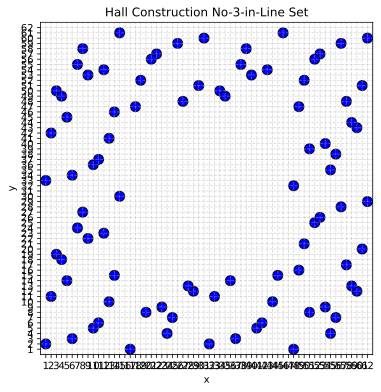

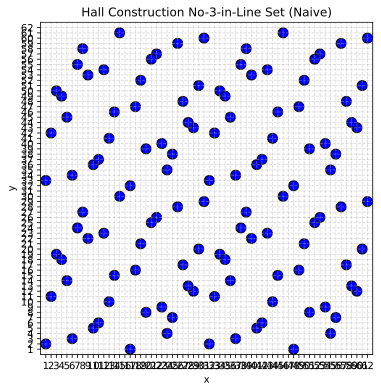

In [85]:
plot_points(points, n=prime*2, title="Hall Construction No-3-in-Line Set")
plot_points(points_naive, n=prime*2, title="Hall Construction No-3-in-Line Set (Naive)")

(<Figure size 600x600 with 1 Axes>,
 <Axes: title={'center': 'Hall Construction No-3-in-Line Set'}, xlabel='x', ylabel='y'>,
 <Figure size 600x600 with 1 Axes>,
 <Axes: title={'center': 'Greedy Selection of Hall Construction No-3-in-Line Set'}, xlabel='x', ylabel='y'>)

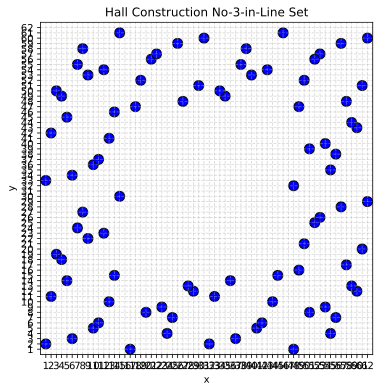

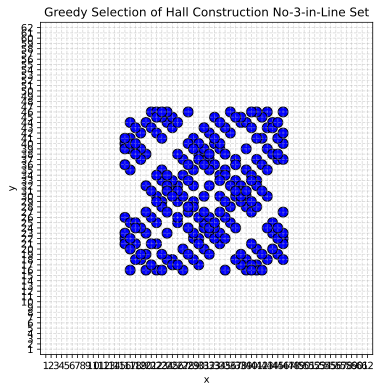

In [86]:
points, initial = greedy(prime*2, pure_random_priority(prime*2), points)

plot_points(points, n=prime*2, title="Hall Construction No-3-in-Line Set") + plot_points(initial, n=prime*2, title="Greedy Selection of Hall Construction No-3-in-Line Set")

In [87]:
len(initial)

240

## Priorities

In [65]:
def pure_random_priority(n):
    def priority(point):
        return 0
    return priority


In [66]:
priority_functions = {
    'pure_random' : pure_random_priority,
}
@parallel(ncpus=CPU_CORES)
def run_greedy_for_strategy(n, strategy_name):
    n_original = n
    n //= 2
    prime = n
    priority_func = priority_functions[strategy_name](n)
    points = hall_construction_n3il(prime, 1)
    result, initial = greedy(prime*2, pure_random_priority(prime*2), points)
    print(f"({n_original},{len(initial)}),")
    return (n_original, len(initial), result)


In [88]:
no_primes = 40
starting_index = 1

In [89]:
primes = primes_first_n(no_primes)
primes = primes[starting_index:]


inputs = [(n*2, 'pure_random') for n in primes]


results_pure_random = run_greedy_for_strategy(inputs)

results_pure_random = [res for (_, res) in results_pure_random]

results_pure_random_raw = [res[2] for res in results_pure_random]

results_pure_random = [res[:2] for res in results_pure_random]



(6,2),
(10,4),
(14,12),
(22,30),
(26,36),
(34,64),
(38,90),
(46,132),
(58,196),
(62,240),
(74,324),
(82,400),
(86,462),
(94,552),
(106,676),
(118,870),
(122,900),
(134,1122),
(142,1260),
(146,1296),
(158,1560),
(166,1722),
(178,1936),
(194,2304),
(214,2862),
(202,2500),
(206,2652),
(218,2916),
(226,3136),
(274,4624),
(254,4032),
(262,4290),
(278,4830),
(298,5476),
(302,5700),
(326,6642),
(314,6084),
(334,6972),
(346,7396),


In [90]:
results = {
    'pure_random_count': results_pure_random,
}

In [91]:
print(results)

{'pure_random_count': [(6, 2), (10, 4), (14, 12), (22, 30), (26, 36), (34, 64), (38, 90), (46, 132), (58, 196), (62, 240), (74, 324), (82, 400), (86, 462), (94, 552), (106, 676), (118, 870), (122, 900), (134, 1122), (142, 1260), (146, 1296), (158, 1560), (166, 1722), (178, 1936), (194, 2304), (214, 2862), (202, 2500), (206, 2652), (218, 2916), (226, 3136), (274, 4624), (254, 4032), (262, 4290), (278, 4830), (298, 5476), (302, 5700), (326, 6642), (314, 6084), (334, 6972), (346, 7396)]}


## Analysis

In [25]:
results = {'leftovers': [(6, 10), (10, 10), (14, 10), (22, 6), (26, 4), (34, 8), (38, 8), (46, 9), (58, 7), (62, 13), (74, 15), (82, 4), (86, 11), (94, 8), (118, 13), (122, 12), (134, 19), (106, 7), (142, 18), (158, 11), (166, 16), (178, 15), (146, 10), (194, 20), (214, 24), (218, 30), (226, 22), (202, 19), (206, 16), (254, 24), (262, 11), (274, 23), (298, 23), (302, 35), (278, 23), (314, 24), (326, 25), (346, 37), (358, 22), (362, 40), (334, 39), (382, 30), (398, 36), (422, 31), (386, 13), (394, 35), (446, 38), (454, 39), (466, 44), (482, 46), (478, 40), (502, 39), (458, 34), (526, 26), (514, 31), (538, 43), (554, 37), (566, 39), (586, 26), (542, 42), (562, 46), (622, 40), (626, 63), (614, 41), (634, 41), (662, 30), (698, 34), (694, 45), (706, 43), (674, 48), (734, 43), (746, 61), (758, 39), (766, 42), (718, 41), (794, 81), (802, 37), (818, 65), (778, 67), (842, 56), (866, 59), (878, 52), (886, 45), (838, 49), (862, 64), (898, 58), (914, 60), (934, 58), (958, 75), (922, 58), (926, 57), (974, 68), (982, 72), (1006, 71), (998, 52), (1018, 72), (1042, 66), (1046, 65), (1082, 76),(1094, 77), (1114, 47), (1142, 62), (1138, 67), (1198, 65), (1186, 59), (1202, 69), (1226, 71), (1174, 67), (1154, 58), (1262, 66), (1238, 70), (1126, 57), (1214, 86), (1282, 59), (1234, 50), (1286, 51), (1306, 91), (1318, 70), (1294, 75), (1322, 76), (1346, 66), (1354, 75), (1382, 81), (1366, 85), (1402, 65), (1438, 51), (1418, 82), (1478, 82), (1454, 84), (1466, 69), (1486, 46), (1502, 87), (1522, 67), (1538, 78), (1514, 86), (1546, 73), (1594, 100), (1574, 92), (1622, 80), (1642, 88), (1618, 73), (1654, 97), (1646, 98), (1658, 70), (1678, 84), (1706, 92), (1714, 77), (1718, 70), (1726, 94)]}


In [26]:
# results = {'pure_random_count': [(6, 2), (10, 4), (14, 12), (22, 30), (26, 36), (34, 64), (38, 90), (46, 132), (58, 196), (62, 240), (82, 400), (74, 324), (94, 552), (86, 462), (106, 676), (122, 900), (118, 870), (134, 1122), (142, 1260), (146, 1296), (158, 1560), (166, 1722), (178, 1936), (194, 2304), (202, 2500), (206, 2652), (218, 2916), (214, 2862), (226, 3136)]}
# pm1 only

In [27]:
# results = {'pure_random_count': [(100, 648), (150, 1128), (200, 2309), (250, 3110), (300, 4879), (350, 6550), (400, 8633), (450, 11246), (500, 13661), (550, 17107), (600, 19675), (650, 25000), (700, 27151), (750, 31626), (800, 34865), (850, 41453), (900, 43570), (950, 52446)]}


In [28]:
'''
results = {'pure_random_count': 

[(100,16),
(150,45),
(200,43),
(250,33),
(300,65),
(350,78),
(400,57),
(500,91),
(450,70),
(550,78),
(600,75),
(650,97),
(700,124),
(750,89),
(900,124),
(800,111),
(850,111),
(950,142),
(1000,93),
(1050,137),
(1100,137),
(1150,156),
(1200,152),
(1250,130),
(1300,152),
(1350,204),
(1400,239)]}
'''

"\nresults = {'pure_random_count': \n\n[(100,16),\n(150,45),\n(200,43),\n(250,33),\n(300,65),\n(350,78),\n(400,57),\n(500,91),\n(450,70),\n(550,78),\n(600,75),\n(650,97),\n(700,124),\n(750,89),\n(900,124),\n(800,111),\n(850,111),\n(950,142),\n(1000,93),\n(1050,137),\n(1100,137),\n(1150,156),\n(1200,152),\n(1250,130),\n(1300,152),\n(1350,204),\n(1400,239)]}\n"

In [40]:
results = {'leftovers': [(6, 2), (10, 1), (14, 2), (22, 3), (26, 7), (34, 3), (38, 11), (46, 9), (58, 8), (62, 16), (74, 15), (82, 19), (86, 9), (94, 21), (118, 22), (106, 18), (122, 19), (146, 28), (134, 17), (142, 26), (158, 26), (166, 39), (178, 41), (194, 33), (206, 24), (202, 24), (214, 37), (218, 38), (226, 39), (262, 47), (278, 41), (254, 51), (314, 46), (326, 63), (274, 45), (334, 48), (346, 54), (302, 60), (358, 61), (298, 48), (362, 51), (382, 43), (386, 73), (398, 68), (394, 55), (422, 29), (446, 65), (466, 75), (478, 69), (454, 62), (482, 69), (458, 69), (502, 86), (514, 69), (526, 64), (538, 77), (542, 78), (554, 88), (566, 70), (586, 84), (562, 76), (622, 77), (626, 71), (634, 89), (614, 83), (662, 94), (694, 103), (674, 104), (698, 73), (706, 98), (734, 70), (746, 126), (718, 135), (758, 100), (766, 106), (778, 107), (794, 119), (802, 99), (818, 90)]}


In [92]:
import matplotlib.pyplot as plt

In [93]:
start = 3

In [94]:
def fit_power_model(points, start=0):
    data = [(x, y) for x, y in points if x > 0 and y > 0]
    log_data = [(log(x), log(y)) for x, y in data[start:]]
    var('log_a k t')
    model(t) = log_a + k * t
    fit = find_fit(log_data, model, solution_dict=True)
    print(f"{exp(fit[log_a])} * x ^ {fit[k]}")
    return exp(fit[log_a]), fit[k]

print(results)


{'pure_random_count': [(6, 2), (10, 4), (14, 12), (22, 30), (26, 36), (34, 64), (38, 90), (46, 132), (58, 196), (62, 240), (74, 324), (82, 400), (86, 462), (94, 552), (106, 676), (118, 870), (122, 900), (134, 1122), (142, 1260), (146, 1296), (158, 1560), (166, 1722), (178, 1936), (194, 2304), (214, 2862), (202, 2500), (206, 2652), (218, 2916), (226, 3136), (274, 4624), (254, 4032), (262, 4290), (278, 4830), (298, 5476), (302, 5700), (326, 6642), (314, 6084), (334, 6972), (346, 7396)]}


In [95]:
def fit_log_model(points, start=0):
    data = [(x, y) for x, y in points if x > 0 and y > 0]
    log_data = [(log(x), y) for x, y in data[start:]]
    var('a b t')
    model(t) = a + b * t
    fit = find_fit(log_data, model, solution_dict=True)
    print(f"{fit[a]} + {fit[b]} * log(x)")
    return fit[a], fit[b]


In [96]:
def fit_linear_model(points, start=0):
    data = [(x, y) for x, y in points if x > 0 and y > 0]
    data = data[start:]
    var('a b t')
    model(t) = a + b * t
    fit = find_fit(data, model, solution_dict=True)
    print(f"{fit[a]} + {fit[b]} * x")
    return fit[a], fit[b]


0.054416031644929225 * x ^ 2.0241290681194957
Fit for pure_random_count: 0.054416031644929225 * x^2.0241290681194957


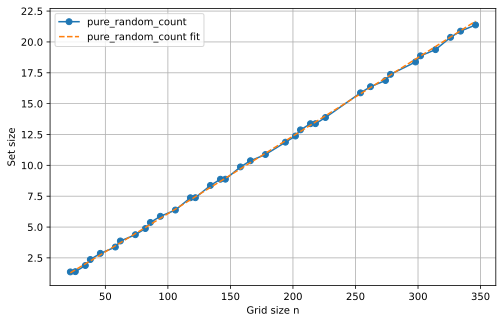

In [97]:
def plot_with_fits(results, start=0):
    plt.figure(figsize=(8, 5))
    for strategy, result_list in results.items():
        result_list.sort(key=lambda x: x[0])
        if result_list:
            plot_data = result_list[start:]
            ns, sizes = zip(*plot_data)
            sizes_normalized = [sizes[i] / ns[i] for i in range(len(sizes))]
            plt.plot(ns, sizes_normalized, marker='o', label=strategy, linestyle='-')

            fit_data = [(x, y) for x, y in result_list[start:] if x > 0 and y > 0]
            if fit_data:
                a, k = fit_power_model(fit_data)
                print(f"Fit for {strategy}: {a} * x^{k}")
                x_fit = np.linspace(min(ns), max(ns), 200)
                y_fit = [a * x**k for x in x_fit]
                y_fit_normalized = [y / x for x, y in zip(x_fit, y_fit)]
                plt.plot(x_fit, y_fit_normalized, linestyle='--', label=f"{strategy} fit")

    plt.xlabel("Grid size n")
    plt.ylabel("Set size")
    plt.grid(True)
    plt.legend()
    plt.show()


plot_with_fits(results, start)


In [98]:
data = results['leftovers']

KeyError: 'leftovers'

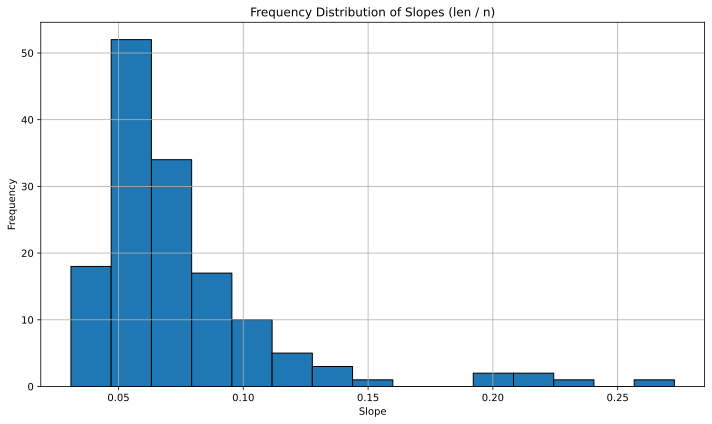

In [36]:
slopes = [length / n * 1.0 for n, length in data]
slopes = slopes[start:] 

# Plot frequency distribution
plt.figure(figsize=(10, 6))
plt.hist(slopes, bins=15, edgecolor='black')
plt.title('Frequency Distribution of Slopes (len / n)')
plt.xlabel('Slope')
plt.ylabel('Frequency')
plt.grid(True)
plt.tight_layout()
plt.show()

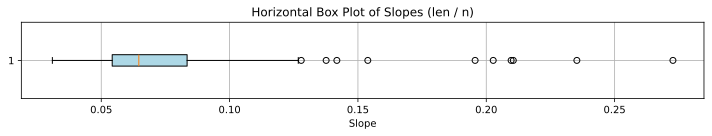

In [37]:
# Generate horizontal box plot of the slopes
plt.figure(figsize=(10, 2))
plt.boxplot(slopes, vert=False, patch_artist=True, boxprops=dict(facecolor='lightblue'))
plt.title('Horizontal Box Plot of Slopes (len / n)')
plt.xlabel('Slope')
plt.grid(True)
plt.tight_layout()
plt.show()


In [38]:
mean_slope = sum(slopes) / len(slopes)
mean_slope

0.0755180058077867

In [39]:
slopes

[0.272727272727273,
 0.153846153846154,
 0.235294117647059,
 0.210526315789474,
 0.195652173913043,
 0.120689655172414,
 0.209677419354839,
 0.202702702702703,
 0.0487804878048781,
 0.127906976744186,
 0.0851063829787234,
 0.0660377358490566,
 0.110169491525424,
 0.0983606557377049,
 0.141791044776119,
 0.126760563380282,
 0.0684931506849315,
 0.0696202531645570,
 0.0963855421686747,
 0.0842696629213483,
 0.103092783505155,
 0.0940594059405941,
 0.0776699029126214,
 0.112149532710280,
 0.137614678899083,
 0.0973451327433628,
 0.0944881889763780,
 0.0419847328244275,
 0.0839416058394161,
 0.0827338129496403,
 0.0771812080536913,
 0.115894039735099,
 0.0764331210191083,
 0.0766871165644172,
 0.116766467065868,
 0.106936416184971,
 0.0614525139664804,
 0.110497237569061,
 0.0785340314136126,
 0.0336787564766839,
 0.0888324873096447,
 0.0904522613065327,
 0.0734597156398104,
 0.0852017937219731,
 0.0859030837004405,
 0.0742358078602620,
 0.0944206008583691,
 0.0836820083682008,
 0.09543568